In [72]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import subprocess as sub
import tempfile

from IPython.display import Image, display

In [60]:
plt.rcParams['figure.figsize'] = 12, 10
plt.rcParams.update({'font.size': 16})

In [2]:
data = pd.read_csv("/data/r2t2/logs/2020-03-30/moana-full-1spp-2/rays-v2.csv.gz",
                   compression='gzip')

In [48]:
sorted_data = (data[data.action.isin(['U'])]
                   .sort_values(['pathId', 'hop', 'timestamp_ms'])).reset_index(drop=True)

In [34]:
treelet_count = np.max(data.treeletId) + 1

In [68]:
def pairs_matrix(data, treelet_count):
    m = np.zeros((treelet_count, treelet_count))
    
    it = data.itertuples()
    start = next(it)
    
    current_treelet = start.treeletId
    next_treelet = None
    
    current_path_id = start.pathId
    
    for row in it:
        if row.pathId != current_path_id:
            current_treelet = row.treeletId
            current_path_id = row.pathId
            continue
            
        next_treelet = row.treeletId
        m[current_treelet, next_treelet] += 1
        current_treelet = next_treelet
        
    return m

In [69]:
m = pairs_matrix(sorted_data, treelet_count)

Text(0, 0.5, 'Treelet Id')

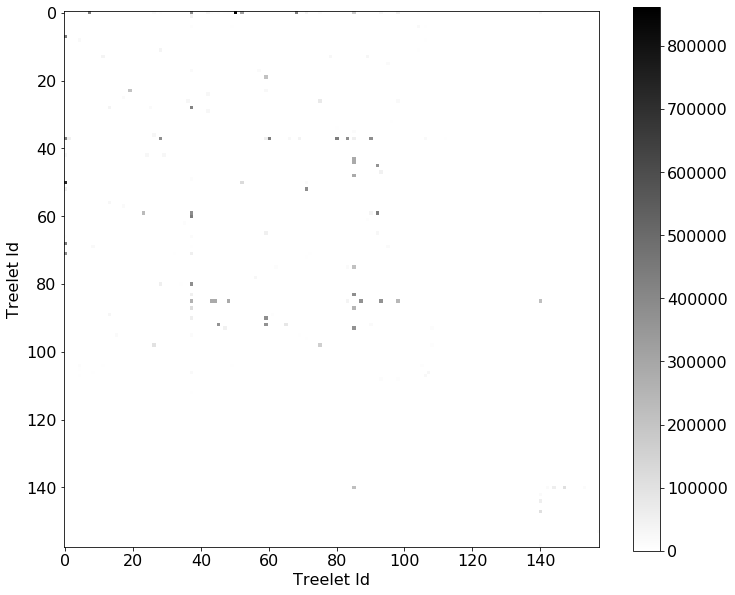

In [71]:
plt.imshow(m, cmap='binary')
plt.colorbar()
plt.xlabel('Treelet Id')
plt.ylabel('Treelet Id')

In [178]:
def parse_graph(dot_file):
    treelet_count = 0
    raw = []
    
    with open(dot_file, "r") as f:
        for line in f:
            if '->' not in line:
                continue
                
            line = line.strip().split(" ")
            src, dst = int(line[0][1:]), int(line[2][1:])
            instance = len(line) > 3
            
            raw += [(src, dst, instance)]
            treelet_count = max(src, dst, treelet_count)
    
    treelet_count += 1
    instance_roots = set([x[1] for x in raw if x[2]])
    graph = {}
    
    for r in raw:
        if not r[2]:
            graph[r[0]] = graph.get(r[0], []) + [r[1]]
    
    treelets = set(range(0, treelet_count))
    
    main_graph = []
    stack = [0]
    
    while len(stack):
        n = stack.pop()
        for x in graph.get(n, []):
            main_graph += [(n, x)]
            stack.append(x)
            
    instance_graphs = {}
    
    for root in instance_roots:
        instance_graphs[root] = []
        
        stack = [root]
        while len(stack):
            n = stack.pop()
            
            for x in graph.get(n, []):
                instance_graphs[root] += [(n, x)]
                stack.append(x)
    
    return main_graph, instance_graphs

def plot_graph(graph, M):
    M = M / np.sum(M)
    
    with tempfile.NamedTemporaryFile(suffix=".gv") as fin, \
         tempfile.NamedTemporaryFile(suffix=".jpg") as fout:
        fin.write(b'digraph bvh {\n')
        fin.write(b'  graph [K=0.6,size="9,9!",dpi=100,ratio="fill",scale=3];')
        fin.write(b'  node [shape=circle,style=filled'
                  b',fillcolor=white,label="",width=0.3];')
        fin.write(b'  edge [arrowhead=vee,arrowsize=0.5];')
        fin.write(b'  overlap = false;\n  splines = true;')

#         for edge in graph:
#             fin.write(f'  T{edge[0]} -> T{edge[1]};\n'.encode('utf-8'))
            
#        for i in range(162):
#            fin.write(f' T{i};\n'.encode('utf-8'))
            
        for i in range(M.shape[0]):
            for j in range(i, M.shape[1]):
                if M[i, j] > 0:
                    fin.write(f' T{i} -> T{j} [penwidth={1}];\n'.encode('utf-8'))
                    fin.write(f' T{i} [label="{i}"];'.encode('utf-8'))
                    fin.write(f' T{j} [label="{j}"];'.encode('utf-8'))
    
            
#         for index, row in data[(data.timestamp_s < timestamp) & (data.raysDequeued > 0)].iterrows():
#             fin.write(f' T{int(row.treeletId)} [fillcolor="green"];\n'.encode('utf-8'))
            
        fin.write(b'}\n')
        fin.flush()
        
        sub.run(["sfdp", "-Tjpg", fin.name, "-o", fout.name], check=True)
        return Image(filename=fout.name)

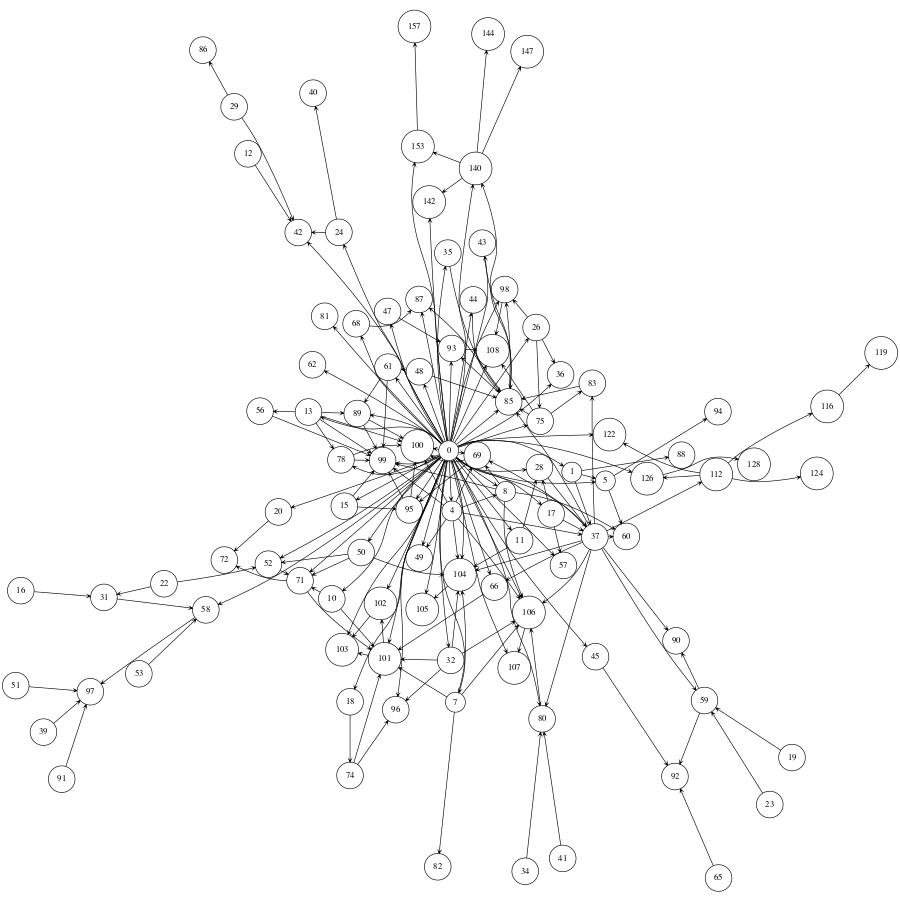

In [179]:
main_graph, instance_graphs = parse_graph("/data/r2t2/scenes/moana-full-nvidia/graph.dot")
plot_graph(main_graph, m)

In [128]:
for i in range(m.shape[0]):
    for j in range(m.shape[1]):
        if m[i, j] > 0:
            print(i, j, int(m[i, j]), sep=',')

0,1,660
0,4,423
0,5,342
0,7,439560
0,8,299
0,10,2
0,11,6
0,13,1525
0,15,1827
0,17,16
0,18,2
0,20,68
0,24,4
0,26,18583
0,28,9811
0,32,2
0,35,298
0,36,2717
0,37,393216
0,42,31584
0,43,12034
0,44,8240
0,45,12093
0,47,3994
0,48,8757
0,49,1374
0,50,861443
0,52,317719
0,57,1294
0,58,3188
0,61,448
0,62,862
0,66,1810
0,68,439296
0,69,276
0,71,39227
0,75,16106
0,78,641
0,80,113
0,81,308
0,85,168350
0,87,369
0,89,158
0,93,30109
0,95,271
0,96,5
0,98,49291
0,99,126
0,100,28
0,101,81
0,102,20
0,103,12
0,104,4076
0,105,935
0,106,2907
0,107,3557
0,108,1427
0,122,1
0,126,1
0,140,25506
0,142,2217
0,153,4073
1,5,1245
1,37,43013
1,88,3128
4,8,659
4,37,9064
4,49,6600
4,69,61
4,99,2
4,100,4
4,104,23199
4,106,5105
5,60,26
5,94,1245
7,0,439211
7,82,85
7,101,346
7,104,1684
7,106,2716
8,4,21842
8,60,20
8,69,659
8,99,17
8,106,6207
10,71,3
10,101,2
11,28,38640
11,104,3846
12,42,2637
13,11,38640
13,56,10
13,78,28628
13,89,30399
13,99,1463
13,100,177
15,95,18930
15,99,281
16,31,620
17,28,14
17,37,19465
17,57,17782